# 1) Download required files 

In [42]:
%%cmd
powershell -Command "Invoke-WebRequest https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py -OutFile ./inferenceutils.py"

Microsoft Windows [Version 10.0.19042.746]
(c) 2020 Microsoft Corporation. All rights reserved.

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>powershell -Command "Invoke-WebRequest https://raw.githubusercontent.com/hugozanini/object-detection/master/inferenceutils.py -OutFile ./inferenceutils.py"

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>

# 2) Extract the saved model

In [43]:
%%cmd
powershell Expand-Archive -Path 'saved_model_frcnn_v1_16022021.zip' -DestinationPath 'saved_model/'

Microsoft Windows [Version 10.0.19042.746]
(c) 2020 Microsoft Corporation. All rights reserved.

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>powershell Expand-Archive -Path 'saved_model_frcnn_v1_16022021.zip' -DestinationPath 'saved_model/'

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>

# 3) Recall model configurations

In [44]:
%%cmd 
move saved_model\content\inference_graph\saved_model\label_map.pbtxt .\label_map.pbtxt
move saved_model\content\inference_graph\saved_model\test_labels.csv .\test_labels.csv
mkdir .\dataset\test
copy saved_model\content\inference_graph\saved_model\test\* .\dataset\test

Microsoft Windows [Version 10.0.19042.746]
(c) 2020 Microsoft Corporation. All rights reserved.

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>move saved_model\content\inference_graph\saved_model\label_map.pbtxt .\label_map.pbtxt
        1 file(s) moved.

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>move saved_model\content\inference_graph\saved_model\test_labels.csv .\test_labels.csv
        1 file(s) moved.

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>mkdir .\dataset\test

C:\Users\azzub\OneDrive - Universiti Sains Malaysia\Desktop\DataMicron\RND\myOCR>copy saved_model\content\inference_graph\saved_model\test\* .\dataset\test
saved_model\content\inference_graph\saved_model\test\Invoice_103_affine_translation.jpg
saved_model\content\inference_graph\saved_model\test\Invoice_107.jpg
saved_model\content\inference_graph\saved_model\test\Invoice_109.jpg
saved_model\content\inference_

In [45]:
output_directory = 'inference_graph'
labelmap_path = 'label_map.pbtxt'

import tensorflow as tf
from object_detection.utils import label_map_util
category_index = label_map_util.create_category_index_from_labelmap(labelmap_path, use_display_name=True)
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'saved_model/content/inference_graph/saved_model')

# 4) Select images to be tested

In [46]:
import pandas as pd
test = pd.read_csv('test_labels.csv')
#Getting 3 random images to test
images = list(test.sample(n=3)['filename'])
images

['Invoice_56.jpg', 'Invoice_56.jpg', 'Invoice_121_brightness.jpg']

In [49]:
from pdf2image import convert_from_path
pages = convert_from_path('Adatum6.pdf')

!mkdir dataset

for page in pages:
    page.save('dataset/adatum_test.jpg', 'JPEG')

A subdirectory or file dataset already exists.


# 5) Test the detection model

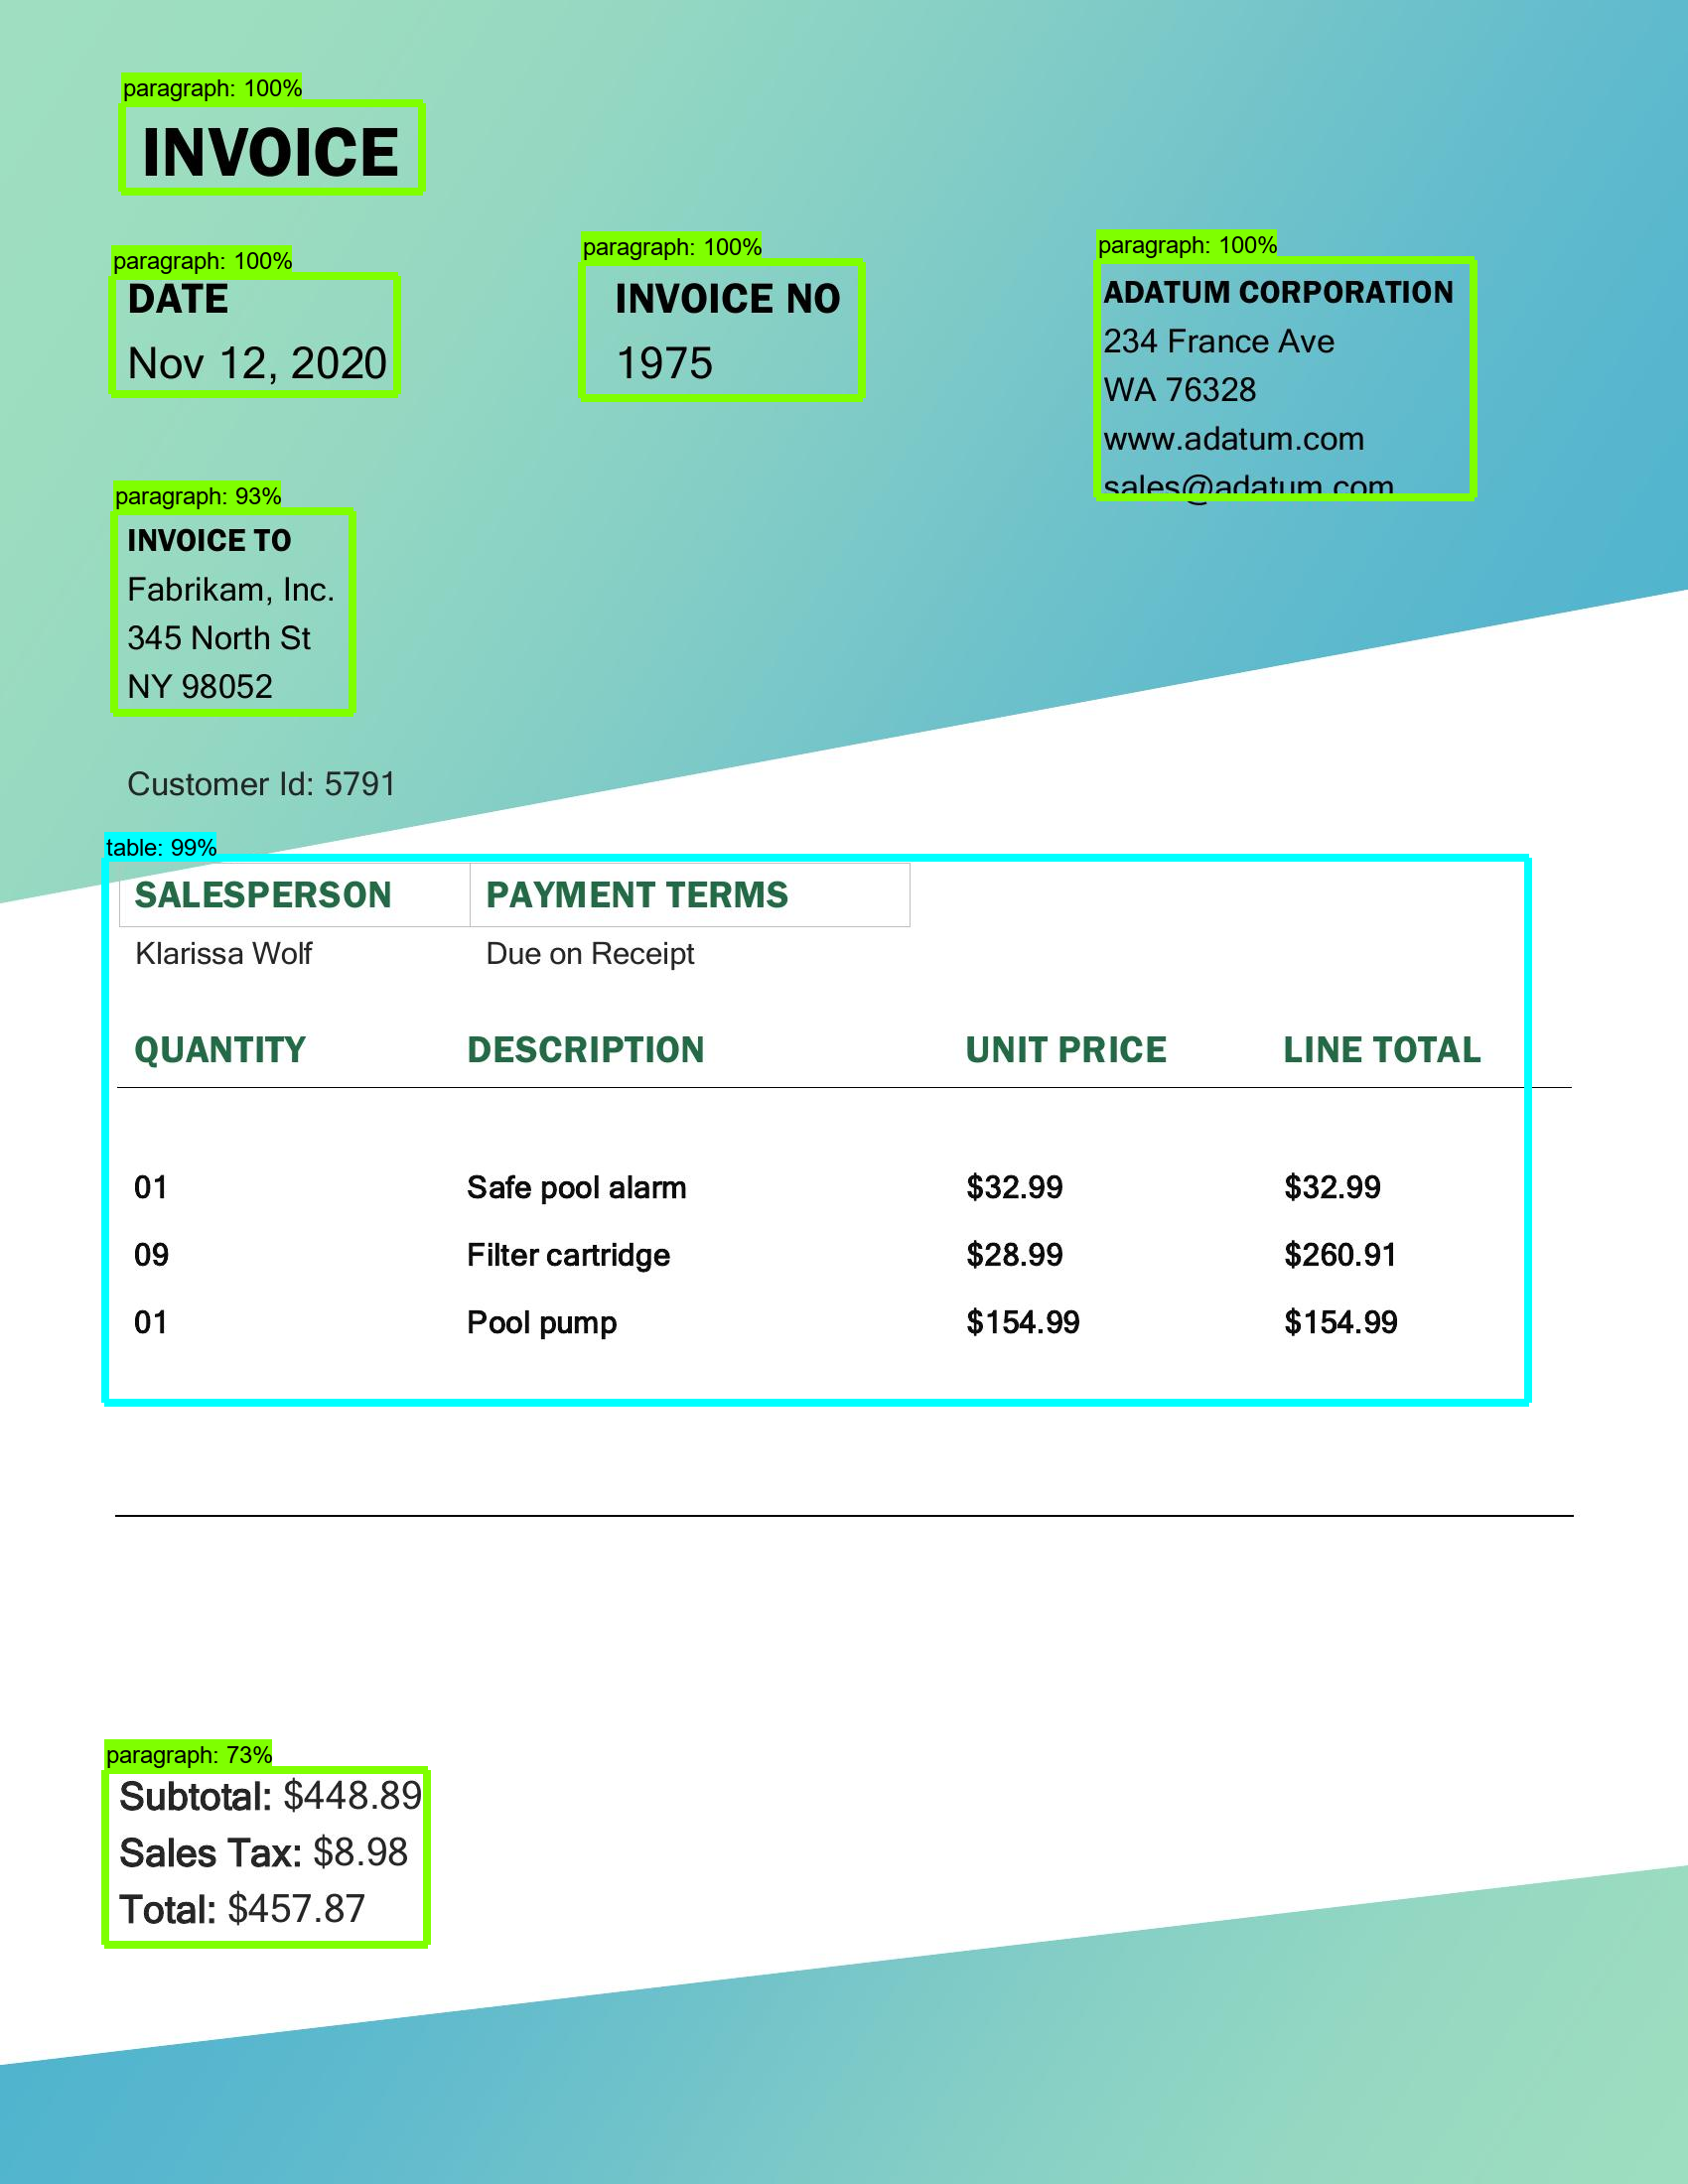

In [50]:
from inferenceutils import *

image_test = 'adatum_test.jpg'
image_np = load_image_into_numpy_array('dataset/'+image_test)
output_dict = run_inference_for_single_image(model, image_np)
vis_util.visualize_boxes_and_labels_on_image_array(
    image_np,
    output_dict['detection_boxes'],
    output_dict['detection_classes'],
    output_dict['detection_scores'],
    category_index,
    instance_masks=output_dict.get('detection_masks_reframed', None),
    use_normalized_coordinates=True,
    line_thickness=8)
display(Image.fromarray(image_np))

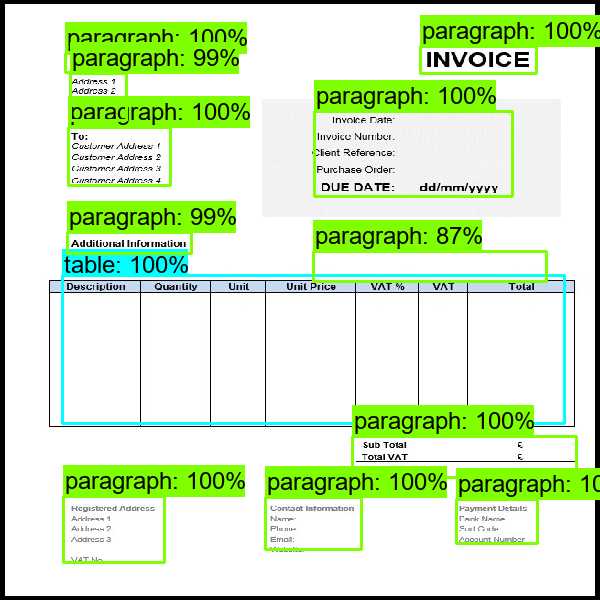

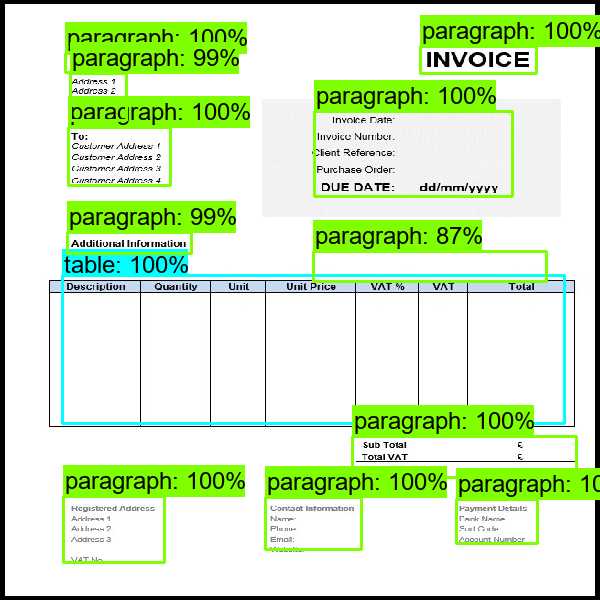

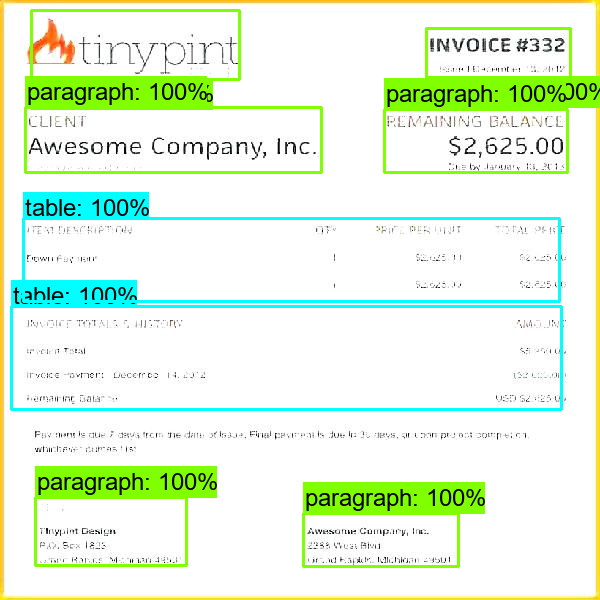

In [53]:
# for multiple images, use this code
for image_name in images:
    image_np = load_image_into_numpy_array('dataset/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    display(Image.fromarray(image_np))

# 6) Export the predicted coordinates as CSV file

In [54]:
# for single image, use this code

import pandas as pd
rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
image_np = load_image_into_numpy_array('dataset/'+image_test)
output_dict = run_inference_for_single_image(model, image_np)
# store boxes in dataframe!
cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))
for j in range(cut_off_scores):
    name = image_test
    scores = output_dict['detection_scores'][j]
    classes = output_dict['detection_classes'][j]
    for i in range(1,len(category_index)+1):
        if output_dict['detection_classes'][j] == category_index[i]['id']:
            classes = category_index[i]['name']
    ymin = output_dict['detection_boxes'][j][0]
    xmin = output_dict['detection_boxes'][j][1]
    ymax = output_dict['detection_boxes'][j][2]
    xmax = output_dict['detection_boxes'][j][3]
    row = list([name, scores, classes, ymin, xmin, ymax, xmax])
    rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('dataset/predicted_coordinates.csv', index = False)
final_df

,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,adatum_test.jpg,0.999299,paragraph,0.119367,0.649661,0.227688,0.873520
1,adatum_test.jpg,0.998966,paragraph,0.126477,0.065920,0.180108,0.235504
2,adatum_test.jpg,0.996288,paragraph,0.047687,0.071766,0.087613,0.250300
3,adatum_test.jpg,0.995500,paragraph,0.120276,0.344557,0.181856,0.511097
4,adatum_test.jpg,0.988213,table,0.393024,0.062122,0.642185,0.905454
5,adatum_test.jpg,0.926101,paragraph,0.234364,0.067633,0.325944,0.208898
6,adatum_test.jpg,0.725307,paragraph,0.810896,0.062161,0.890081,0.253218


In [57]:
rows = []

final_dataframe = pd.DataFrame(columns=['Image','Score','Class','Ymin','Xmin','Ymax','Xmax'])
for image_name in images:
  
    image_np = load_image_into_numpy_array('dataset/test/' + image_name)
    output_dict = run_inference_for_single_image(model, image_np)

    # store boxes in dataframe!
    cut_off_scores = len(list(filter(lambda x: x >= 0.1, output_dict['detection_scores'])))

    for j in range(cut_off_scores):
        name = image_name
        scores = output_dict['detection_scores'][j]
        classes = output_dict['detection_classes'][j]
        for i in range(1,len(category_index)+1):
            if output_dict['detection_classes'][j] == category_index[i]['id']:
                classes = category_index[i]['name']
        ymin = output_dict['detection_boxes'][j][0]
        xmin = output_dict['detection_boxes'][j][1]
        ymax = output_dict['detection_boxes'][j][2]
        xmax = output_dict['detection_boxes'][j][3]

        row = list([name, scores, classes, ymin, xmin, ymax, xmax])
        rows.append(row)

final_df = pd.DataFrame(rows, columns = ['Image', 'Scores', 'Classes', 'ymin', 'xmin', 'ymax', 'xmax'])
final_df.to_csv('predicted_coordinates.csv', index = False)
final_df

,Image,Scores,Classes,ymin,xmin,ymax,xmax
0,Invoice_56.jpg,0.999767,table,0.459763,0.104882,0.705264,0.940243
1,Invoice_56.jpg,0.999418,paragraph,0.727458,0.587551,0.795573,0.961320
2,Invoice_56.jpg,0.999202,paragraph,0.211822,0.113454,0.309980,0.284516
3,Invoice_56.jpg,0.999133,paragraph,0.828418,0.442052,0.916054,0.601986
4,Invoice_56.jpg,0.999036,paragraph,0.185277,0.523648,0.327266,0.854624
5,Invoice_56.jpg,0.998946,paragraph,0.827169,0.105138,0.937046,0.274298
6,Invoice_56.jpg,0.998818,paragraph,0.089547,0.109721,0.121622,0.353655
7,Invoice_56.jpg,0.998565,paragraph,0.077729,0.701466,0.121794,0.894064
8,Invoice_56.jpg,0.998056,paragraph,0.832623,0.760376,0.906350,0.895663
9,Invoice_56.jpg,0.993396,paragraph,0.122702,0.117178,0.200893,0.210835
